In [427]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from sklearn.linear_model import LinearRegression, BayesianRidge
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import GradientBoostingRegressor
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout

import warnings
warnings.filterwarnings('ignore')

In [428]:
# Load the dataset
disaster = pd.read_csv("C:/Users/john_/Desktop/MSDS/MSDS_422/Final_Project/natural_disasters_2024.csv")

In [429]:
# Check the dataset shape
print(f"Dataset has {disaster.shape[0]} entries, and {disaster.shape[1]} features.")

Dataset has 10000 entries, and 7 features.


In [430]:
disaster.head()

,Disaster_ID,Disaster_Type,Location,Magnitude,Date,Fatalities,Economic_Loss($)
0,1,Wildfire,Brazil,6.267393,2024-01-01 00:00:00,9706,6.509790e+08
1,2,Hurricane,Indonesia,6.649358,2024-01-01 01:00:00,2233,5.538357e+08
2,3,Tornado,China,9.724366,2024-01-01 02:00:00,478,6.910998e+07
3,4,Flood,India,1.702505,2024-01-01 03:00:00,2867,8.474880e+08
4,5,Flood,Brazil,7.917748,2024-01-01 04:00:00,776,6.449297e+08


## Exploratory Data Analysis/Feature Engineering

In [431]:
# Identify target
y = disaster['Economic_Loss($)']

# Drop Disaster id
disaster.drop(['Disaster_ID'], axis = 1, inplace = True)

In [432]:
# Check for missing values
print(disaster.isnull().sum())

Disaster_Type       0
Location            0
Magnitude           0
Date                0
Fatalities          0
Economic_Loss($)    0
dtype: int64


In [433]:
# Check unique values for catergorical features
for col in disaster.select_dtypes(include=['object']).columns:
    print(f"{col}: {disaster[col].nunique()} unique values")

Disaster_Type: 5 unique values
Location: 6 unique values
Date: 10000 unique values


In [434]:
for i in disaster['Disaster_Type'].unique():
    print(i)
    
print()
for j in disaster['Location'].unique():
    print(j)

Wildfire
Hurricane
Tornado
Flood
Earthquake

Brazil
Indonesia
China
India
USA
Japan


<Axes: title={'center': 'Economic Loss Distribution'}, xlabel='Economic_Loss($)'>

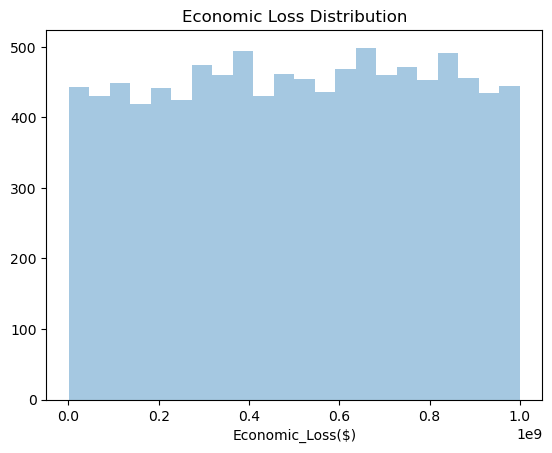

In [435]:
# Distribution of target
plt.figure()
plt.title('Economic Loss Distribution')
sns.distplot(y, kde = False)

In [436]:
quantitative = [f for f in disaster.columns if disaster.dtypes[f] != 'object']

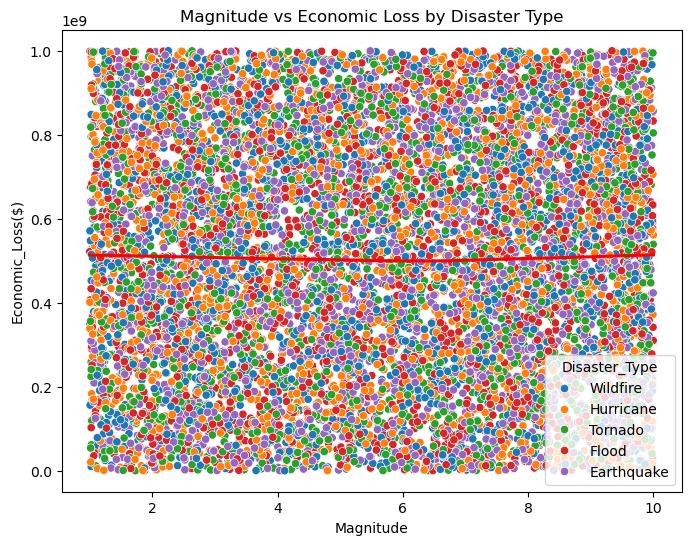

In [437]:
# Scatterplot for Economic Loss vs Magnitude, differentiated by disaster type
plt.figure(figsize=(8, 6))
sns.scatterplot(x = 'Magnitude', y = 'Economic_Loss($)', hue = 'Disaster_Type', data = disaster)
sns.regplot(x = disaster['Magnitude'], 
            y = y, 
            scatter=False, 
            lowess=True, 
            color='red')
plt.title('Magnitude vs Economic Loss by Disaster Type')
plt.show()

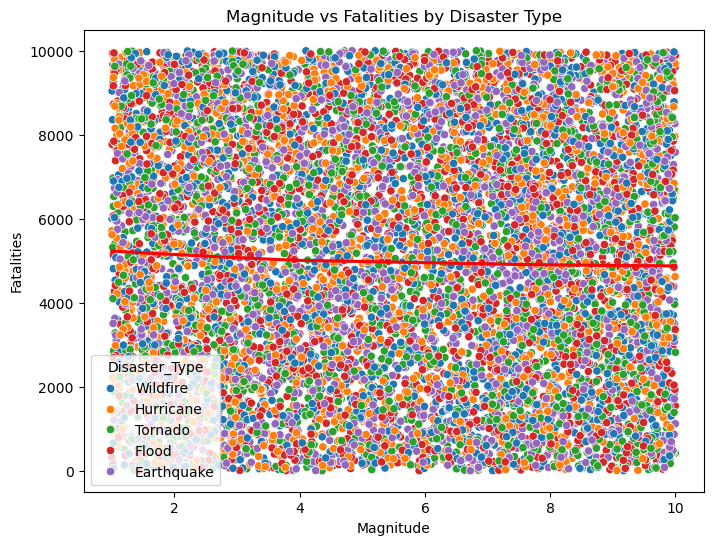

In [438]:
# Scatterplot for Magnitude vs Fatalities, differentiated by disaster type
plt.figure(figsize=(8, 6))
sns.scatterplot(x = 'Magnitude', y = 'Fatalities', hue = 'Disaster_Type', data = disaster)
sns.regplot(x = disaster['Magnitude'], 
            y = disaster['Fatalities'], 
            scatter=False, 
            lowess=True, 
            color='red')
plt.title('Magnitude vs Fatalities by Disaster Type')
plt.show()

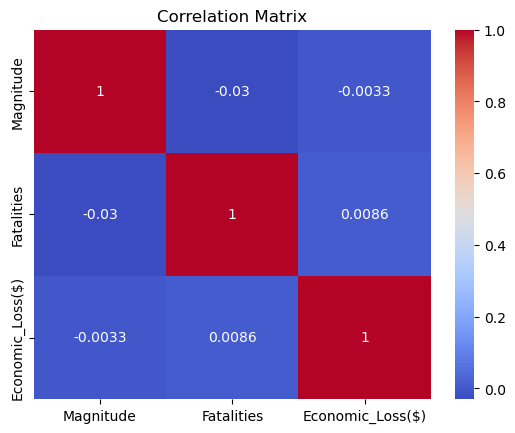

In [439]:
# Create a correlation matrix using quantitative features
plt.figure()
sns.heatmap(disaster[quantitative].corr(), annot = True, cmap = 'coolwarm')
plt.title('Correlation Matrix')
plt.show()

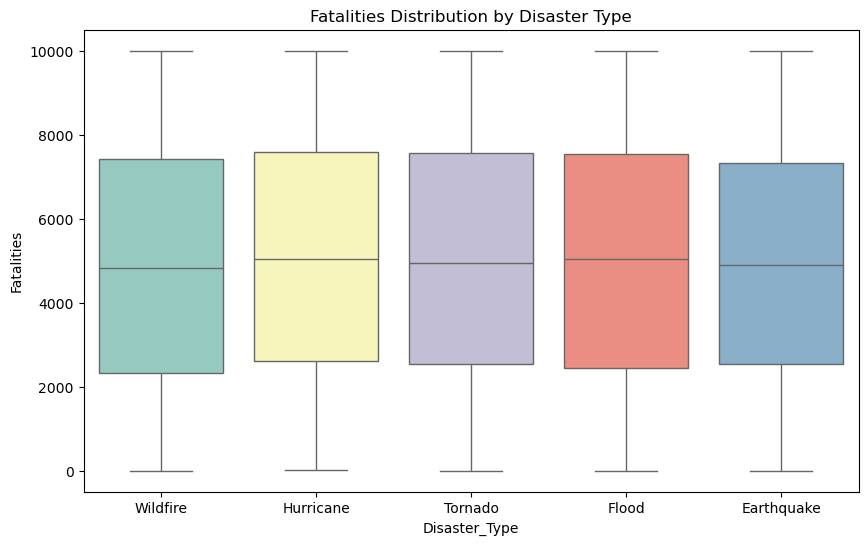

In [440]:
# Boxplot of Fatalities by Disaster Type
plt.figure(figsize=(10, 6))
sns.boxplot(x = 'Disaster_Type', y = 'Fatalities', data = disaster, palette='Set3')
plt.title('Fatalities Distribution by Disaster Type')
plt.show()

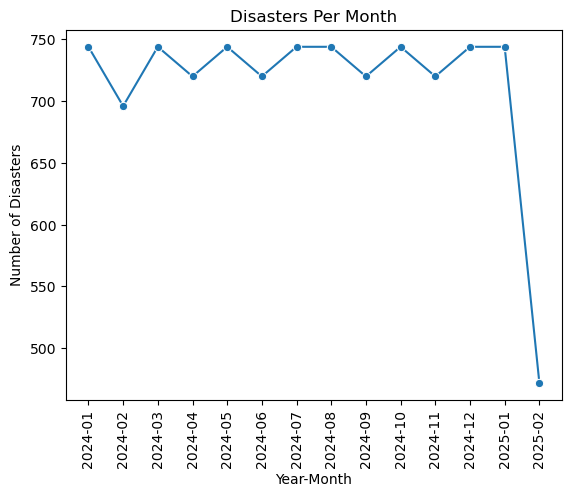

In [441]:
# Time series anaylsis (Disasters Per Month)
disaster['Date'] = pd.to_datetime(disaster['Date'])
disaster['Year-Month'] = disaster['Date'].dt.to_period('M')
disasters_per_year = disaster.groupby('Year-Month').size()

plt.figure()
sns.lineplot(x = disasters_per_year.index.astype(str), y = disasters_per_year.values, marker = 'o')
plt.xticks(rotation=90)
plt.title('Disasters Per Month')
plt.xlabel('Year-Month')
plt.ylabel('Number of Disasters')
plt.show()

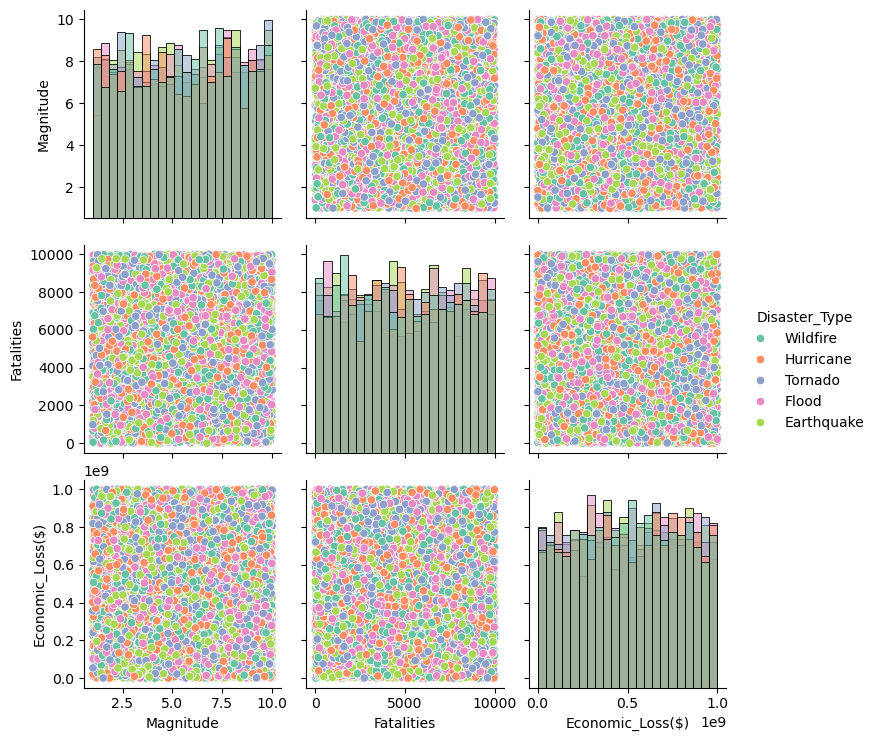

In [442]:
# Pairplot for numerical features to detect relationships and outliers
sns.pairplot(disaster[['Magnitude', 'Fatalities', 'Economic_Loss($)', 'Disaster_Type']], hue = 'Disaster_Type', diag_kind = 'hist', palette = 'Set2')
plt.show()

In [443]:
# Feature Engineering

# $Loss Per Fatality
disaster['Loss_Per_Fatality'] = disaster['Economic_Loss($)'] / disaster['Fatalities'].replace(0 , 1)

# Log Transform target
disaster['Log_Economic_Loss'] = np.log1p(disaster['Economic_Loss($)'])

# Remove 2025-02 rows for consistency
disaster = disaster[disaster['Year-Month'] != '2025-02']

## Preprocessing for Model Implementation

In [444]:
# Extract features and target
X = disaster.drop(columns = ['Economic_Loss($)', 'Log_Economic_Loss'])
y = disaster['Log_Economic_Loss']

In [445]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

# Preprocessing
categorical_features = ['Disaster_Type', 'Location', 'Year-Month']
numerical_features = ['Magnitude', 'Fatalities', 'Loss_Per_Fatality']

preprocessor = ColumnTransformer([
    ('cat', OneHotEncoder(drop = 'first', sparse = False), categorical_features),
    ('num', StandardScaler(), numerical_features)
])

In [446]:
# Transform the train and test sets
X_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed = preprocessor.transform(X_test)

## Model Training and Fitting

In [447]:
# Helper function to export a CSV file with the predictions
def predictions_csv(model_name, y_test_actual, y_pred, file_name):
    os.makedirs(os.path.dirname(file_name), exist_ok=True)
    
    results = pd.DataFrame({
        "Actual_Economic_Loss": np.expm1(y_test_actual),
        "Predicted_Economic_Loss": np.expm1(y_pred)
    })
    results.to_csv(file_name, index = False)
    print(f"{model_name} predictions saved to {file_name}")

### Linear Regression

In [448]:
# Initialize and fit the model
linear_model = LinearRegression()
linear_model.fit(X_train_transformed, y_train)

# Make the predictions on the test set
y_pred = linear_model.predict(X_test_transformed)

# Model evaluation
scaled_actual = np.expm1(y_test) / 1e9
scaled_predicted = np.expm1(y_pred) / 1e9

mse_scaled = mean_squared_error(scaled_actual, scaled_predicted)
mse = mse_scaled * 1e9
r2 = r2_score(np.expm1(y_test), np.expm1(y_pred))

print(f"Linear Regression Results:")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"R-squared Score: {r2:.2f}")
predictions_csv("Linear Regression", y_test, y_pred, "predictions/linear_regression_predictions.csv")

Linear Regression Results:
Mean Squared Error (MSE): 98264315.25
R-squared Score: -0.17
Linear Regression predictions saved to predictions/linear_regression_predictions.csv


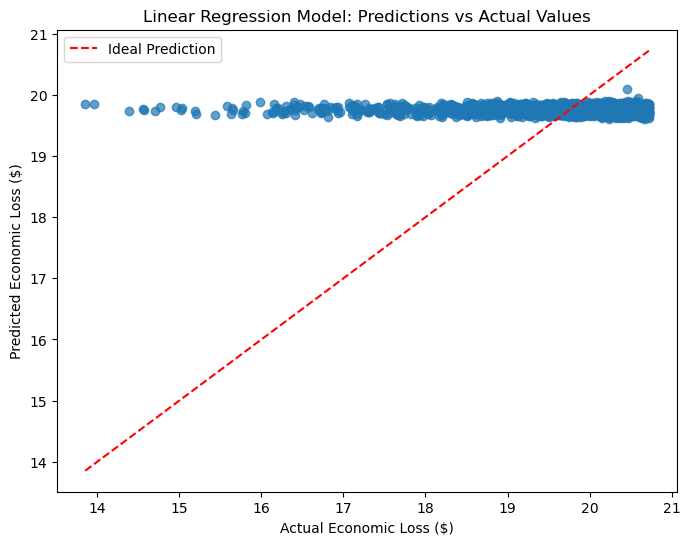

In [449]:
# Visualize the Predictions
plt.figure(figsize = (8, 6))
plt.scatter(y_test, y_pred, alpha = 0.7)
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         '--',
         color = 'red',
         label = 'Ideal Prediction')
plt.title("Linear Regression Model: Predictions vs Actual Values")
plt.xlabel("Actual Economic Loss ($)")
plt.ylabel("Predicted Economic Loss ($)")
plt.legend()
plt.show()

### Gradient Boosting Regressor

In [450]:
# Initialize Gradient Boosting Regressor
gbm = GradientBoostingRegressor(n_estimators = 500,
                                learning_rate = 0.05,
                                max_depth = 5,
                                random_state = 42)
# Fit the model
gbm.fit(X_train_transformed, y_train)

# Predict on the test set
y_pred_gbr = gbm.predict(X_test_transformed)

# Model Evaluation
scaled_actual = np.expm1(y_test) / 1e9
scaled_predicted = np.expm1(y_pred_gbr) / 1e9

mse_scaled = mean_squared_error(scaled_actual, scaled_predicted)
mse = mse_scaled * 1e9
r2 = r2_score(np.expm1(y_test), np.expm1(y_pred_gbr))

print(f"Gradient Boosting Regressor Results:")
print(f"Mean Squared Error (MSE): {mse: .2f}")
print(f"R-squared Score: {r2:.2f}")
predictions_csv("Gradient Boosting Regressor", y_test, y_pred_gbr, "predictions/gradient_boosting_predictions.csv")

Gradient Boosting Regressor Results:
Mean Squared Error (MSE):  378035.16
R-squared Score: 1.00
Gradient Boosting Regressor predictions saved to predictions/gradient_boosting_predictions.csv


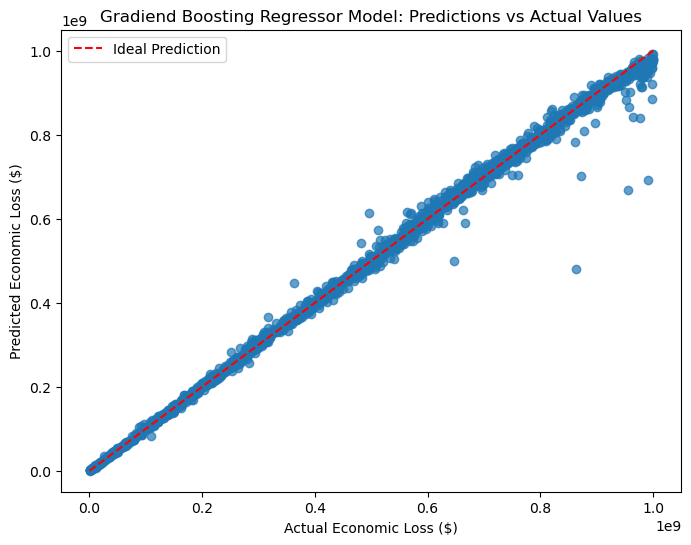

In [451]:
# Visualize the Predictions
plt.figure(figsize = (8, 6))
plt.scatter(np.expm1(y_test), np.expm1(y_pred_gbr), alpha = 0.7)
plt.plot([np.expm1(y_test).min(), np.expm1(y_test).max()],
         [np.expm1(y_test).min(), np.expm1(y_test).max()],
         '--',
         color = 'red',
         label = 'Ideal Prediction')
plt.title("Gradiend Boosting Regressor Model: Predictions vs Actual Values")
plt.xlabel("Actual Economic Loss ($)")
plt.ylabel("Predicted Economic Loss ($)")
plt.legend()
plt.show()

### Bayesian Ridge Regressor

Bayesian Ridge Regressor Results:
Mean Squared Error (MSE): 97275063.10
R-squared Score: -0.16
Bayesian Ridge Regressor predictions saved to predictions/bayesian_ridge_predictions.csv


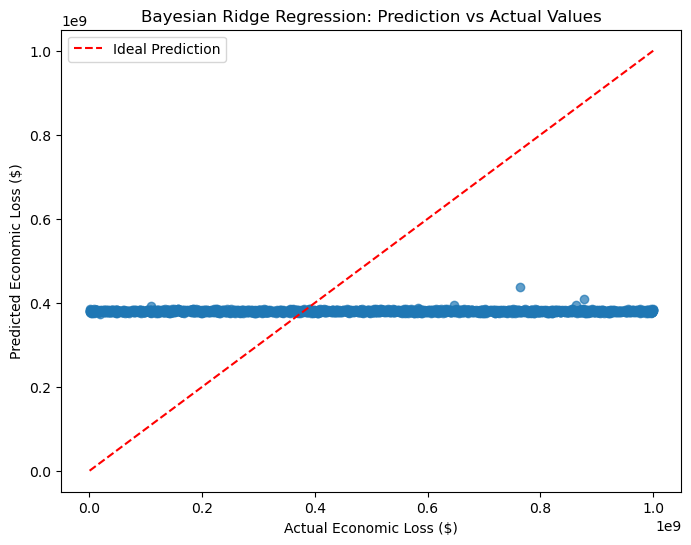

In [452]:
# Initialize Bayesian Ridge Regressor
bayesian_ridge = BayesianRidge()

# Fit the model on the training data
bayesian_ridge.fit(X_train_transformed, y_train)

# Predict on the test set
y_pred_brr = bayesian_ridge.predict(X_test_transformed)

# Model Evaluation
scaled_actual = np.expm1(y_test) / 1e9
scaled_predicted = np.expm1(y_pred_brr) / 1e9

mse_scaled = mean_squared_error(scaled_actual, scaled_predicted)
mse = mse_scaled * 1e9
r2 = r2_score(np.expm1(y_test), np.expm1(y_pred_brr))

print(f"Bayesian Ridge Regressor Results:")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"R-squared Score: {r2:.2f}")
predictions_csv("Bayesian Ridge Regressor", y_test, y_pred_brr, "predictions/bayesian_ridge_predictions.csv")

# Plot Predictions vs Actual Values
plt.figure(figsize = (8, 6))
plt.scatter(np.expm1(y_test), np.expm1(y_pred_brr), alpha = 0.7)
plt.plot([np.expm1(y_test).min(), np.expm1(y_test).max()],
         [np.expm1(y_test).min(), np.expm1(y_test).max()],
         '--',
         color = 'red',
         label = 'Ideal Prediction')
plt.title("Bayesian Ridge Regression: Prediction vs Actual Values")
plt.xlabel("Actual Economic Loss ($)")
plt.ylabel("Predicted Economic Loss ($)")
plt.legend()
plt.show()

### Recurrent Neural Network(RNN)

In [453]:
# Process the date data
disaster['Year-Month'] = disaster['Year-Month'].dt.to_timestamp()
disaster = disaster.sort_values('Year-Month')

In [454]:
# Group the data by Year-Month
monthly_data = disaster.groupby('Year-Month').agg({
    'Economic_Loss($)': 'mean',
    'Magnitude': 'mean',
    'Loss_Per_Fatality': 'mean'
}).reset_index()

In [455]:
# Extract the target and the features
features = ['Magnitude', 'Loss_Per_Fatality']
target = 'Economic_Loss($)'

X = monthly_data[features].values
y = monthly_data[target].values

In [456]:
# Scaling for the features
scaler_X = MinMaxScaler()
X_scaled = scaler_X.fit_transform(X)

# Scaling for the target variable
y_log = np.log1p(y)
scaler_y = MinMaxScaler()
y_scaled = scaler_y.fit_transform(y_log.reshape(-1, 1))

In [457]:
# Reshape the data for RNN
timesteps = 2
X_rnn, y_rnn = [], []

for i in range(len(X_scaled) - timesteps):
    X_rnn.append(X_scaled[i : i + timesteps])
    y_rnn.append(y_scaled[i + timesteps])
    
X_rnn = np.array(X_rnn)
y_rnn = np.array(y_rnn)

In [458]:
# Train-test split
split_index = int(0.8 * len(X_rnn))
X_train, X_test = X_rnn[:split_index], X_rnn[split_index:]
y_train, y_test = y_rnn[:split_index], y_rnn[split_index:]

In [459]:
# Create the RNN model
rnn_model = Sequential([
    LSTM(64, activation = 'relu', input_shape = (timesteps, len(features)), return_sequences = True),
    Dropout(0.2),
    LSTM(32, activation = 'relu'),
    Dropout(0.2),
    Dense(1)
])

In [460]:
# Compile the model
rnn_model.compile(optimizer = 'adam', loss = 'mse', metrics = ['mse'])

In [461]:
# Model training
rnn_model.fit(X_train, y_train, epochs = 50, batch_size = 8, validation_split = 0.2, verbose = 1)

Epoch 1/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - loss: 0.3060 - mse: 0.3060 - val_loss: 0.1324 - val_mse: 0.1324
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.3047 - mse: 0.3047 - val_loss: 0.1301 - val_mse: 0.1301
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 0.3021 - mse: 0.3021 - val_loss: 0.1279 - val_mse: 0.1279
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 0.2977 - mse: 0.2977 - val_loss: 0.1260 - val_mse: 0.1260
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.2968 - mse: 0.2968 - val_loss: 0.1243 - val_mse: 0.1243
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.2929 - mse: 0.2929 - val_loss: 0.1227 - val_mse: 0.1227
Epoch 7/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 0.2873 - mse: 0.2873 - val_loss: 0.1209 - val_mse: 0.1209
Epoch 8/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.2830 - mse: 0.2830 - val_loss: 0.1191 - val_mse: 0.1191
Epoch 9/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 0.2827 - mse: 0.2827 - va

In [462]:
# Model Predictions on the test set
y_pred_scaled = rnn_model.predict(X_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step


Recurrent Neural Network Results:
Mean Squared Error (MSE): 737511.41
R-squared Score: 0.00
Recurrent Neural Network predictions saved to predictions/rnn_predictions.csv


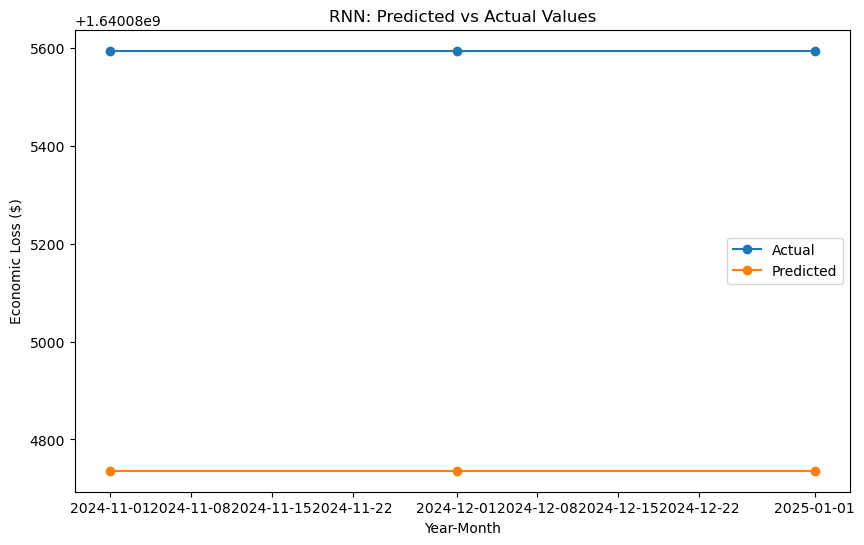

In [463]:
# Reverse the log transformation
y_pred_clipped = np.clip(y_pred_scaled, scaler_y.data_min_[0], scaler_y.data_max_[0])
y_pred_log = scaler_y.inverse_transform(y_pred_clipped)
y_pred = np.expm1(np.nan_to_num(y_pred_log))

y_test_scaled_clipped = np.clip(y_test, scaler_y.data_min_[0], scaler_y.data_max_[0])
y_test_actual_log = scaler_y.inverse_transform(y_test_scaled_clipped)
y_test_actual = np.expm1(np.nan_to_num(y_test_actual_log))

# Model Evaluation
mse_rnn = mean_squared_error(y_test_actual, y_pred)
r2_rnn = r2_score(y_test_actual, y_pred)

print(f"Recurrent Neural Network Results:")
print(f"Mean Squared Error (MSE): {mse_rnn:.2f}")
print(f"R-squared Score: {r2_rnn:.2f}")
predictions_csv("Recurrent Neural Network", y_test_actual_log.flatten(), y_pred_log.flatten(), "predictions/rnn_predictions.csv")

# Plot Predictions vs Actual Values
plt.figure(figsize = (10,6))
plt.plot(monthly_data['Year-Month'][-len(y_pred):], y_test_actual, label = 'Actual', marker = 'o')
plt.plot(monthly_data['Year-Month'][-len(y_pred):], y_pred, label = 'Predicted', marker = 'o')
plt.title("RNN: Predicted vs Actual Values")
plt.xlabel("Year-Month")
plt.ylabel("Economic Loss ($)")
plt.legend()
plt.show()